In [132]:
import os
import logging


from wordcloud import WordCloud



from typing import List, Tuple, Dict, Any, Union
import matplotlib.pyplot as plt
import dill
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive

from cities.utils.data_grabber import find_repo_root
root = find_repo_root()

full zoning dataset within the period 410
after dropping university 326
154


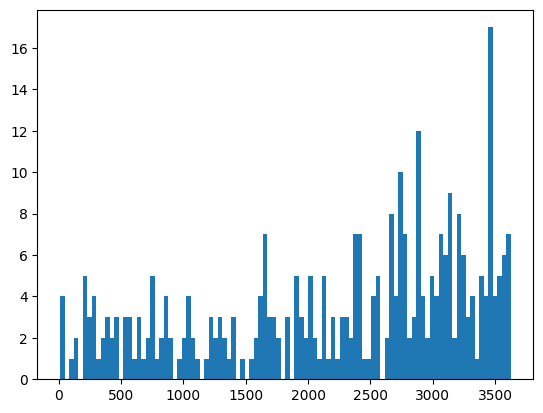

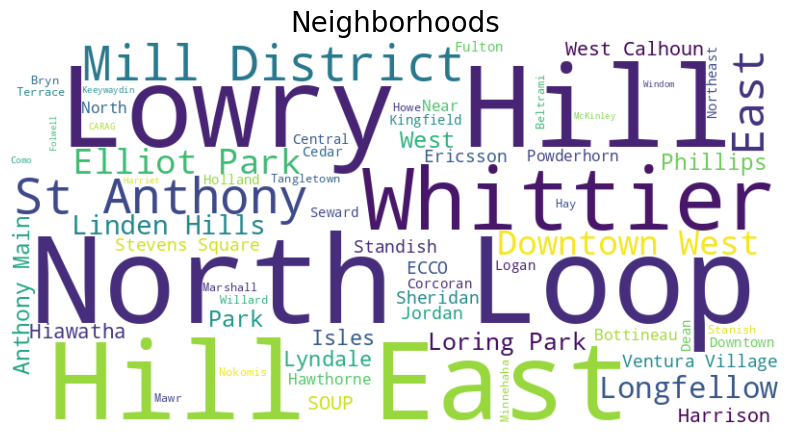

0.7116564417177914
limit
eliminated    190
full           82
reduced        54
Name: count, dtype: int64
neigh [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
wards [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


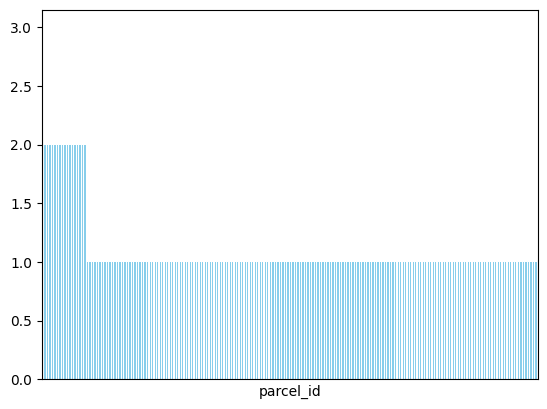

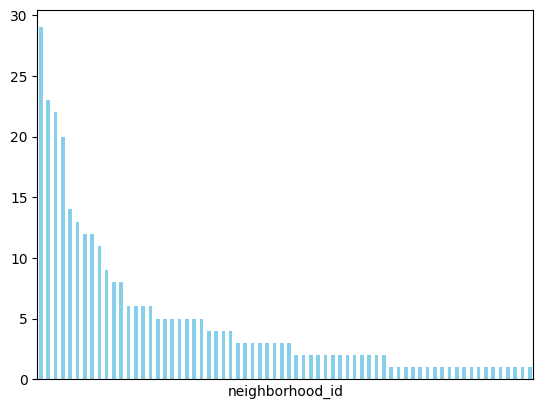

Index(['parcel_id', 'date', 'neighborhood', 'ward', 'downtown_yn',
       'housing_units', 'car_parking', 'bike_parking', 'parcel_area',
       'university_yn', 'res_parking_elim_2015_yn',
       'res_parking_reduced_2015_yn', 'year', 'year_id', 'month', 'day',
       'past_reform', 'limit', 'limit_id', 'month_id', 'day_id',
       'neighborhood_id', 'ward_id', 'housing_units_std', 'car_parking_std',
       'parcel_area_std'],
      dtype='object')


,parcel_id,date,neighborhood,ward,downtown_yn,housing_units,car_parking,bike_parking,parcel_area,university_yn,...,past_reform,limit,limit_id,month_id,day_id,neighborhood_id,ward_id,housing_units_std,car_parking_std,parcel_area_std
0,2602924310063,2011-01-10,Elliot Park,6,True,7,0,0,7245.893155,False,...,False,eliminated,0,0,0,0,0,-0.893078,-0.821149,-0.621041
1,102824440106,2011-01-10,Stanish Ericsson,12,False,64,74,80,38210.631831,False,...,False,full,2,0,0,1,1,-0.338982,-0.111109,0.011602
2,2702924430325,2011-01-10,Stevens Square,6,False,123,104,62,73747.490123,False,...,False,full,2,0,0,2,0,0.234556,0.176745,0.737659
3,3302924440363,2011-02-07,Lowry Hill East,10,False,198,240,108,70847.105465,False,...,False,full,2,1,1,3,2,0.963630,1.481683,0.678401
5,1702823340059,2011-04-11,Nokomis East,12,False,42,42,21,52590.828770,False,...,False,full,2,2,2,4,1,-0.552844,-0.418154,0.305405


In [109]:
zoning_raw = pd.read_csv(os.path.join(root,"data/minneapolis/sourced/per_unit_parking.csv"))


#drop project name, address
zoning = zoning_raw.drop(columns=["project_name","address"])

# check nas
nas = zoning.isna().sum()
assert nas.sum() == 0


zoning['date'] = pd.to_datetime(zoning['date'])
start_date = pd.to_datetime('2011-01-01')

zoning['year'] = zoning['date'].dt.year
zoning['year_id'] = pd.factorize(zoning['year'])[0]

#drop year > 2020
zoning = zoning[zoning['year'] <= 2020]

#drop university of minnesota
print("full zoning dataset within the period", len(zoning))
zoning = zoning[zoning['university_yn'] == False]
print("after dropping university", len(zoning)) 


zoning['month'] = zoning['date'].dt.month
zoning['day']  = (zoning['date'] - start_date).dt.days


plt.hist(zoning['day'], bins=100) #note not only within-permit limits but also numbers of permissions is important

print(len(zoning['day'].unique())) # note it seems like there have been 171 days with updates,
                                   # reason to believe that the data is not really daily


# wordcloud to quickly check for typos
text = ' '.join(zoning['neighborhood'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neighborhoods', fontsize=20)
plt.show()



# parking reform was passed: July 10, 2015
reform = pd.to_datetime('2015-07-10')
reform_day = (reform - start_date).days

zoning['past_reform'] = zoning['date'] > reform

print(
zoning['past_reform'].mean()
#note 71 % permits are after the reform
)





criteria = ['past_reform', 'res_parking_elim_2015_yn', 'res_parking_reduced_2015_yn']

replacement_dict = {
    'FalseFalseFalse': 'full',
    'FalseTrueFalse': 'full',
    'FalseFalseTrue': 'full',
    'FalseTrueTrue': 'full',
    'TrueFalseFalse': 'full',
    'TrueTrueFalse': 'eliminated',
    'TrueFalseTrue': 'reduced',
    'TrueTrueTrue': 'eliminated' 
}

zoning['limit'] = zoning[criteria].astype(str).agg(''.join, axis=1).replace(replacement_dict)

zoning.loc[zoning['downtown_yn'], 'limit'] = 'eliminated'

limit_ordering = ['eliminated', 'reduced', 'full']

zoning['limit'] = pd.Categorical(zoning['limit'], categories=limit_ordering, ordered=True)

zoning['limit_id'] = zoning['limit'].cat.codes

#sanity check
print(zoning['limit'].value_counts())



columns_to_factorize = ['year', 'month', 'day', 'neighborhood', 'ward']

for column in columns_to_factorize:
    zoning[column + '_id'] = pd.factorize(zoning[column])[0]



print("neigh", zoning['neighborhood_id'].unique() )
print("wards", zoning['ward_id'].unique() )
# 76 neighborhoods, 13 wards


# note one or two permits per parcel, no strong reason to use parcels as units of analysis
zoning['parcel_id'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks([])
plt.show()


# we might have a shot with neighborhoods as units of analysis
zoning['neighborhood_id'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks([])
plt.show()


columns_to_standardize = ['housing_units', 'car_parking', 'parcel_area']

for column in columns_to_standardize:
    zoning[column + '_std'] = (zoning[column] - zoning[column].mean()) / zoning[column].std()


print(zoning.columns)
display(zoning.head())


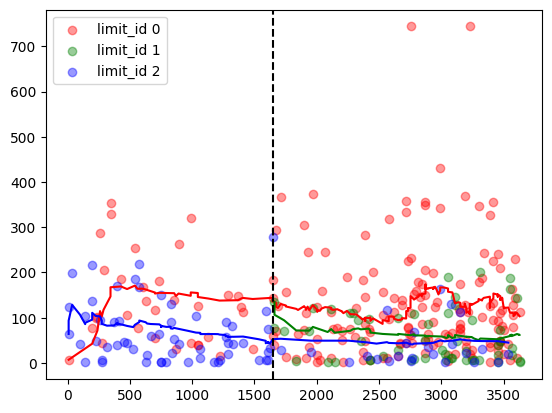

In [108]:
window_size = 30


rolling_avgs = {}
for limit_id, group in zoning.groupby('limit_id'):
    rolling_avgs[limit_id] = group['housing_units'].rolling(window_size, min_periods=1).mean()

rolling_total = zoning['housing_units'].rolling(window_size, min_periods=1).sum()
rolling_avg = zoning['housing_units'].rolling(window_size, min_periods=1).mean()


for limit_id, color in enumerate(['red', 'green', 'blue']):
    plt.scatter(x=zoning[zoning['limit_id'] == limit_id]['day'], y=zoning[zoning['limit_id'] == limit_id]['housing_units'],
                alpha=0.4, c=color, label=f'limit_id {limit_id}')
    plt.plot(zoning[zoning['limit_id'] == limit_id]['day'], rolling_avgs[limit_id], c=color)

plt.axvline(reform_day, color='black', linestyle='--')

# possibly plot running total sum
#plt.plot(zoning['day'], rolling_total, c='black', label='total', linestyle='--')

#possibly plot running average
#plt.plot(zoning['day'], rolling_avg, c='black', label='total', linestyle='--')


plt.legend()
plt.show()

# note the red line doesn't have to upwards to show that the lower limits have effect

# also: think hard what it is that we care about trying to predict, there are many ways to conceptualize the problem

# for now, the question we're trying to aswer is: what is the effect of limit class on the number of housing units

In [136]:
# tensor prep

housing_units = torch.tensor(zoning['housing_units_std'].values, dtype=torch.float)


parcel_area = torch.tensor(zoning['parcel_area_std'].values, dtype=torch.float)

limit_id = torch.tensor(zoning['limit_id'].values, dtype=torch.long)
neighborhood_id = torch.tensor(zoning['neighborhood_id'].values, dtype=torch.long)

outcome = housing_units

categorical = {'limit_id': limit_id,
               'neighborhood_id': neighborhood_id}

continuous = {"parcel_area": parcel_area} #with an eye on generality



In [168]:
class SimpleLinear(pyro.nn.PyroModule):
    def __init__(self, categorical: Dict[str,torch.Tensor], continuous: Dict[str,torch.Tensor], outcome: torch.Tensor,
                 leeway = .9):
        super().__init__()

        self.categorical_names = list(categorical.keys())
        self.categorical_stacked = torch.stack(list(categorical.values()), dim=0)

        self.continuous_names = list(continuous.keys())
        self.continuous_stacked = torch.stack(list(continuous.values()), dim=0)

        self.outcome = outcome
        
        self.n = len(outcome)
        self.N_categorical = self.categorical_stacked.shape[0]
        
        self.categorical_levels = dict()
        for name in self.categorical_names:
            self.categorical_levels[name] = (torch.unique(categorical[name]))

        self.leeway = leeway    


    def forward(self):
        pass 
        
        data_plate = pyro.plate("data", size=self.n, dim=-1)
        categorical_plate = pyro.plate("categorical", size=self.N_categorical, dim=-2)
        

        with categorical_plate:
            bias_categorical = pyro.sample("bias_categorical", dist.Normal(0., self.leeway))
            sigma_categorical = pyro.sample("sigma_categorical", dist.Exponential(1.))


            weights_categorical = dict()
            for name in self.categorical_names:
                with pyro.plate(name, size=len(self.categorical_levels[name]), dim=-1):
                    print("bah")
                    weights_categorical[name] = pyro.sample(f"weights_{name}", dist.Normal(0., self.leeway))


            #weights_categorical_outcome = pyro.sample("weights_categorical_outcome", dist.Normal(0., self.leeway))


        #continuous_plate = pyro.plate("continuous", size=self.n, dim=-3)
        

   


   

#        with pyro.plate("data", size=n, dim=-1):
        
        # with pyro.plate("data", size=n, dim=-1):
            

simple_linear = SimpleLinear(categorical, continuous, outcome)

simple_linear.categorical_names
simple_linear.n
print("categorical", simple_linear.N_categorical)
simple_linear.categorical_stacked.shape[0]
simple_linear.categorical_levels


with pyro.poutine.trace() as tr:
    simple_linear()

for site in tr.trace.nodes.values():
    if site["type"] == "sample":
        print(site['name'], site['value'].shape)


categorical 2
bah
bah
data torch.Size([326])
categorical torch.Size([2])
bias_categorical torch.Size([2, 1])
sigma_categorical torch.Size([2, 1])
limit_id torch.Size([3])
neighborhood_id torch.Size([68])
